## Hughes

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
from aggregators import (
    race, 
    income, 
    redlining, 
    plot_race, 
    speed_breakdown, 
    bucket_and_bin
)

In [3]:
# inputs
fn_hughes = "../data/output/speed_price_hughes.csv.gz"
fn_all_hughes = "../data/open_address/processed/csv/city_of_boston-addresses-city.csv.gz"

# outputs
fn_speed = "../data/output/figs/fig1_huges.csv"
fn_fig3a = "../data/output/figs/fig3_income.csv"
fn_fig3b = "../data/output/figs/fig3_race.csv"
fn_fig3c = "../data/output/figs/fig3_redline.csv"

# notebook variable
ISP = 'Hughes Net'

In [4]:
hughes = pd.read_csv(fn_hughes, compression='gzip')
len(hughes)

13

In [5]:
all_hughes = pd.read_csv(fn_all_hughes, compression='gzip')
len(all_hughes)

19

In [6]:
hughes["median_household_income"]

0      65871.0
1      49286.0
2      26302.0
3          NaN
4     120250.0
5     150823.0
6      15547.0
7      27277.0
8      27969.0
9          NaN
10         NaN
11     29954.0
12         NaN
Name: median_household_income, dtype: float64

In [7]:
print('Percent of households not served: ', str(round(len(hughes)/len(all_hughes)*100, 2))+'%')

Percent of households not served:  68.42%


In [8]:
hughes = hughes[hughes.speed_down != 0]
len(hughes)

13

In [9]:
hughes = bucket_and_bin(hughes)
hughes.head()

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,race_perc_non_white,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income,speed_down_bins,race_quantile,is_slow
0,"1, Templeton Way, Boston, MA, 02124",Boston,Boston,MA,42.289794,-71.057208,3,1.701787e+09,hughes,15,...,0.810795,0.863338,15530.152999,3.0,10427.0,0.940000,65871.0,Slow (<25 Mbps),most white,1
1,"12, Albion Street, Boston, MA, 02119",Boston,Boston,MA,42.322130,-71.071630,2,1.701787e+09,hughes,15,...,0.974165,0.645967,8563.334682,2.0,27012.0,0.751131,49286.0,Slow (<25 Mbps),least white,1
2,"19, Everton Street, Boston, MA, 02121",Boston,Boston,MA,42.304910,-71.072680,3,1.701787e+09,hughes,15,...,0.916580,0.344727,5095.724161,2.0,49996.0,0.775342,26302.0,Slow (<25 Mbps),more white,1
3,"75, Peterborough Street, Boston, MA, 02215",Boston,Boston,MA,42.343730,-71.098270,4,1.701787e+09,hughes,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slow (<25 Mbps),NaN,1
4,"149, Charles Street, Boston, MA, 02114",Boston,Boston,MA,42.360479,-71.070570,3,1.701787e+09,hughes,15,...,0.096899,1.576057,22588.779155,3.0,-43952.0,0.945568,120250.0,Slow (<25 Mbps),most white,1


In [10]:
# who gets options?
hughes[
    (hughes["speed_down"] != hughes["fastest_speed_down"])
    & (~hughes["fastest_speed_down"].isnull())
]["speed_down"].value_counts(normalize=True)

speed_down
15    1.0
Name: proportion, dtype: float64

In [11]:
# make the above for each city:
city2speeds = pd.DataFrame()
for (city, state), _df in hughes.groupby(["major_city", "state"]):
    row = _df.speed_down_bins.value_counts(normalize=True, sort=False).to_frame().T
    row.reset_index(drop=True, inplace=True)
    row["major_city"] = city.title()
    row["state"] = state
    city2speeds = pd.concat([city2speeds, row])
city2speeds.to_csv(fn_speed, index=False)

city2speeds

speed_down_bins,No service,Slow (<25 Mbps),Medium (25-99),Fast (100-199),Blazing (≥200),major_city,state
0,0.0,1.0,0.0,0.0,0.0,Boston,MA


In [12]:
# variety = hughes.groupby(['major_city', 'state']).speed_down_bins.value_counts(normalize=True)
# homogenous_cities = variety[variety >= .95].index.get_level_values(0)
# len(homogenous_cities)

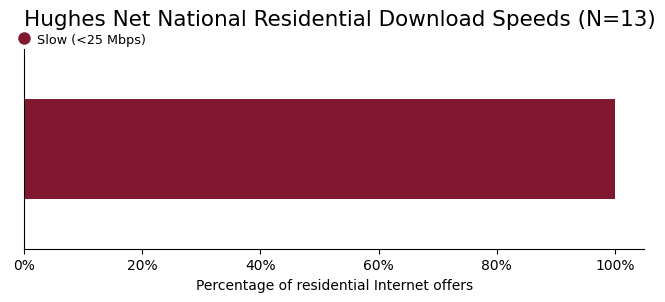

In [14]:
speed_breakdown(hughes, isp=ISP)

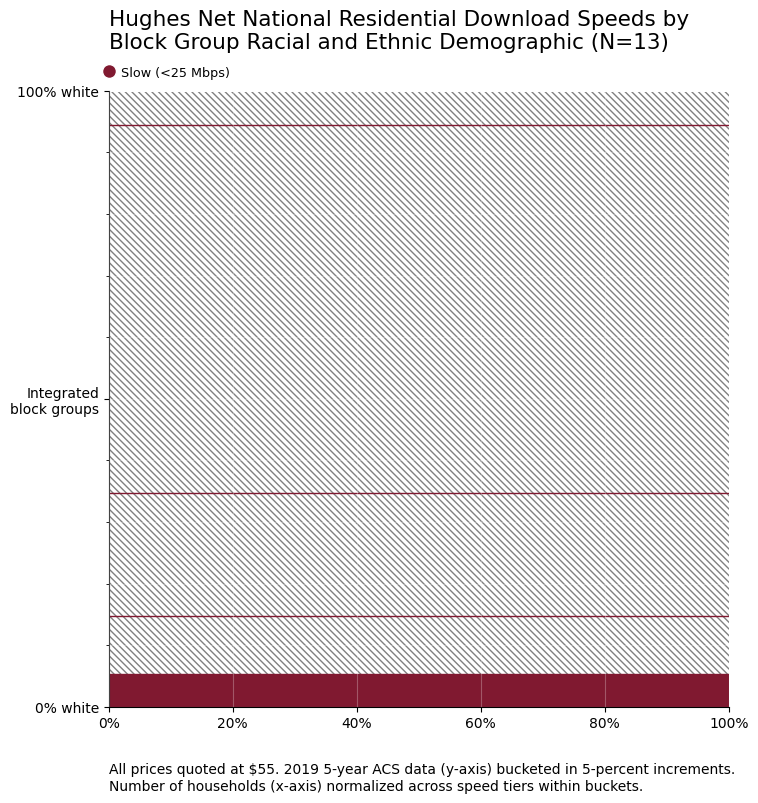

In [15]:
plot_race(hughes, ISP)

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("race_quantile")


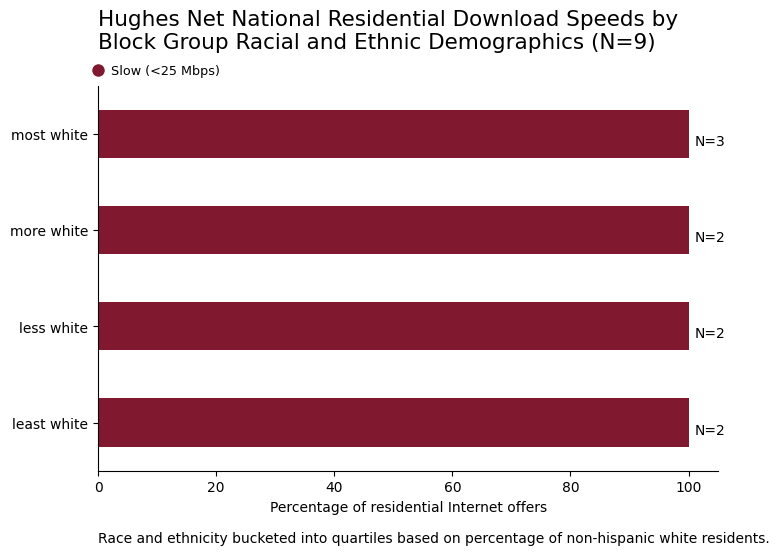

In [17]:
race(hughes, ISP)

In [18]:
income(hughes, ISP)

KeyError: 'income_level'

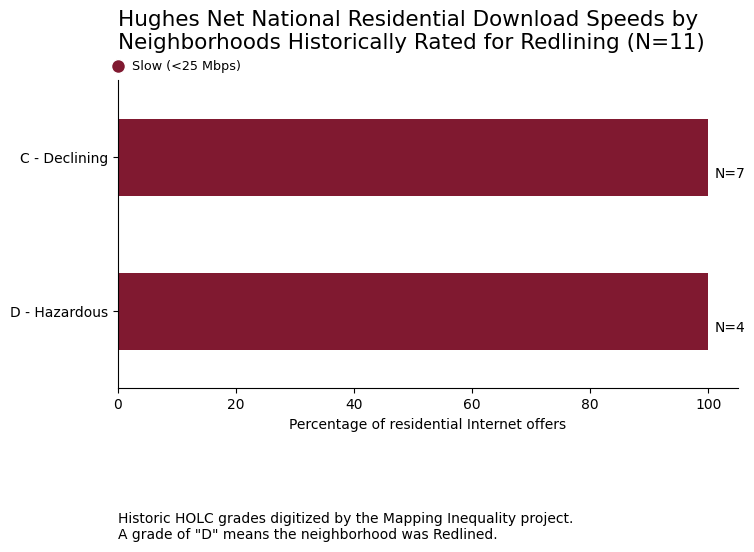

In [19]:
redlining(hughes, ISP)

## City by City

Boston


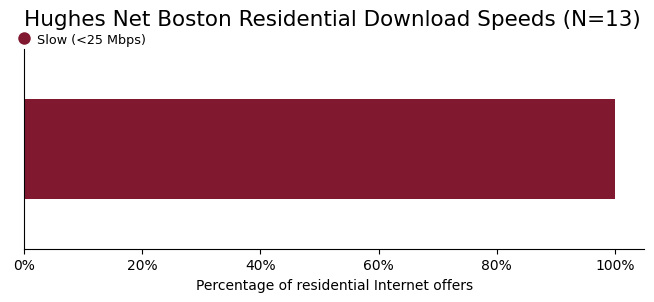

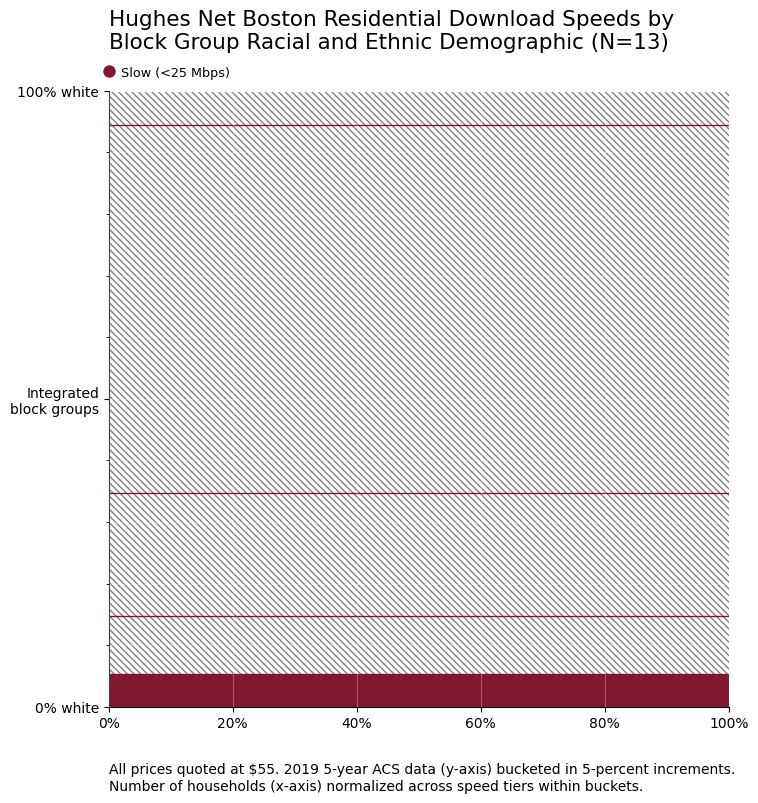

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:197: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("race_quantile")


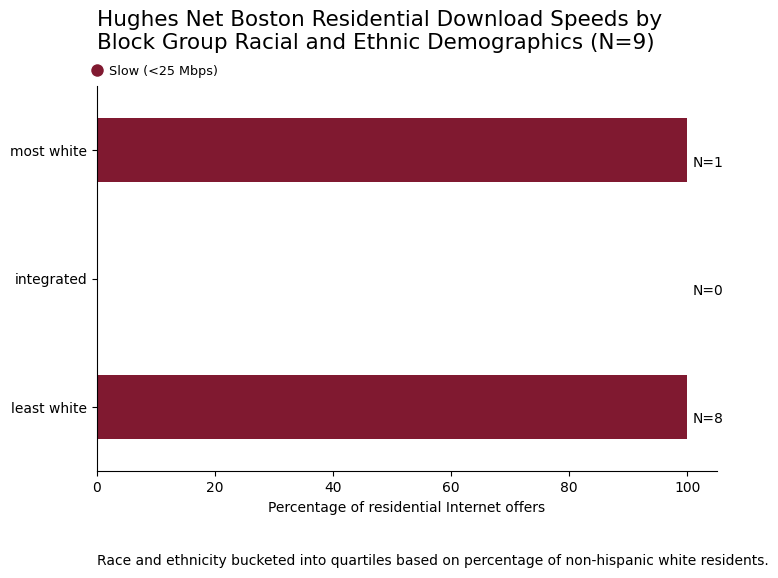

c:\Users\J-Dog\23FALL\Algorithm Audits\investigate_NE_isp\notebooks\aggregators.py:283: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("income_level")


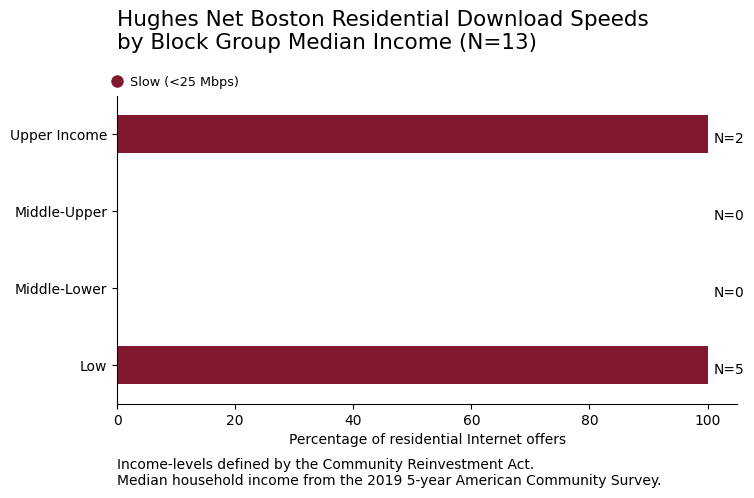

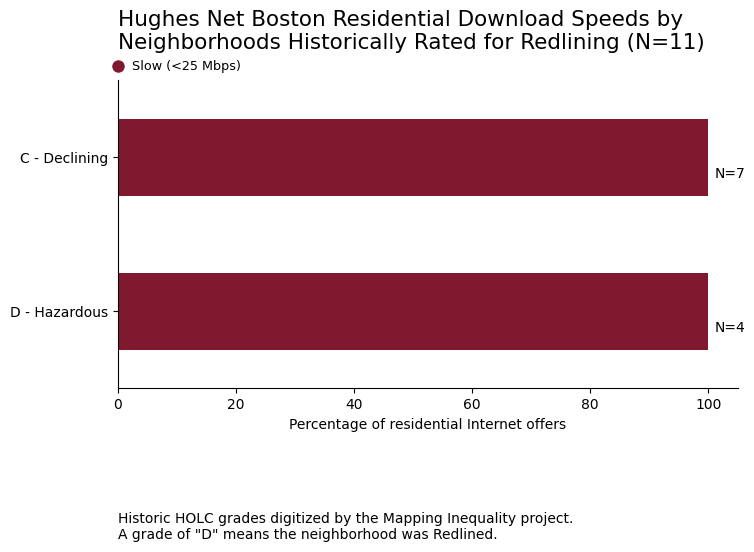

*******************************************************************************


In [45]:
for city, _df in hughes.groupby("major_city"):
    print(city)
    _df = bucket_and_bin(_df, ISP)
    speed_breakdown(_df, ISP, location=city.title())
    plot_race(_df, ISP, location=city.title())
    race(_df, ISP, location=city.title())
    income(_df, ISP, location=city.title())
    redlining(_df, ISP, location=city.title())
    fn_out = f"../data/intermediary/maps/att/{city}_offers.csv"
    if not os.path.exists(fn_out):
        os.makedirs(os.path.dirname(fn_out), exist_ok=True)
        _df.to_csv(fn_out, index=False)
    print("*" * 79)

## One city's graphs as an example

In [20]:
from pandas.api.types import CategoricalDtype
from config import income_labels

In [21]:
# outputs
fn_fig3a = '../data/output/figs/fig3_income.csv'
fn_fig3b = '../data/output/figs/fig3_race.csv'
fn_fig3c = '../data/output/figs/fig3_redline.csv'

In [29]:
df_city = bucket_and_bin(hughes[hughes.major_city == "Boston"])

In [31]:
df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
     CategoricalDtype(income_labels, ordered=True)
).copy(deep=True)

to_plot = (df_city.groupby('income_level').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3a)

KeyError: 'income_level'

In [32]:
to_plot = (df_city.groupby('race_quantile').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3b)

C:\Users\J-Dog\AppData\Local\Temp\ipykernel_34200\546127959.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  to_plot = (df_city.groupby('race_quantile').speed_down_bins


In [33]:
to_plot = (df_city.groupby('redlining_grade').speed_down_bins
             .value_counts(normalize=True)
             .sort_index() * 100 ).unstack()
to_plot.to_csv(fn_fig3c)

In [34]:
# outputs
fn_fig_story_a = '../data/output/figs/story_income_{city}.csv'
fn_fig_story_b = '../data/output/figs/story_race_{city}.csv'
fn_fig_story_c = '../data/output/figs/story_redline_{city}.csv'

In [35]:
for city in ['new orleans']:
    df_city = bucket_and_bin(hughes[hughes.major_city == city])
    df_city.loc[:, 'income_level'] = df_city['income_level'].astype(
         CategoricalDtype(income_labels, ordered=True)
    ).copy(deep=True)

    to_plot = (df_city.groupby('income_level').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_a.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('race_quantile').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_b.format(city=city.replace(' ', '_')))
    to_plot = (df_city.groupby('redlining_grade').speed_down_bins
                 .value_counts(normalize=True)
                 .sort_index() * 100 ).unstack()
    to_plot['major_city'] = city
    to_plot.to_csv(fn_fig_story_c.format(city=city.replace(' ', '_')))

IndexError: single positional indexer is out-of-bounds

In [36]:
# how many addresses got 6 Mbps or less
len(hughes[hughes.speed_down <= 6])

0

In [37]:
# how many cities got 6 Mbps or less
hughes[hughes.speed_down <= 6].major_city.nunique()

0